In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import librosa
from matplotlib import pyplot as plt
from IPython import display as ipd
import numpy as np

In [3]:
audio, sr = librosa.load('../kaggle-birds/dataset/wavs_32k/aldfly/XC134874.wav', sr=32000)

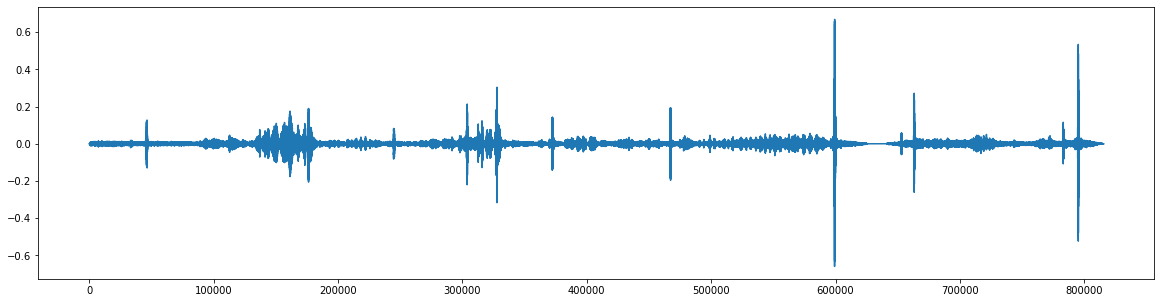

In [4]:
plt.figure(figsize=(20,5))
plt.plot(audio)

# Full model

In [10]:
from utils import MelSpectrogramModel
import torch

In [31]:
model_resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [32]:
model_resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
def resnet_BW(resnet):
    resnet.conv1.in_channels = 1
    conv1_shape = np.array(resnet.conv1.weight.data.shape)
    conv1_shape[1] = 1
    # Las componentes RGB son todas iguales, tomo factor comun y los pesos se suman
    resnet.conv1.weight.data = resnet.conv1.weight.data.sum(axis=1).reshape(*conv1_shape)
    return resnet

In [42]:
model_resnet_bw = resnet_BW(model_resnet)

In [51]:
model_resnet_bw.fc.weight.shape[1]

512

In [44]:
mel_model = MelSpectrogramModel()

In [78]:
class BirdsNet(torch.nn.Module):
    def __init__(self, window_size=2048, hop_size=128, n_mels=128, sr=22050, pretrained=True, n_classes=264, resnet_type='resnet18', init_fourier=True, init_mel=True, train_fourier=False, train_mel=False, a=-1.2, fully_connected=False, fmin=0.0, fmax=None, dropout=0.2):
        super().__init__()
        
        
        self.mel_spectrogram = MelSpectrogramModel(
            window_size = window_size, train_fourier=train_fourier, sr=sr, hop_size=hop_size, n_mels=n_mels, train_mel=train_mel, fmin=fmin, fmax=fmax
        )

        self.a = torch.nn.Parameter(torch.tensor([a]))
        
        self.bn1 = torch.nn.BatchNorm2d(1)
        
        model_resnet = torch.hub.load('pytorch/vision:v0.6.0', resnet_type, pretrained=pretrained)
        model_resnet_BW = resnet_BW(model_resnet)
        
        self.resnet = torch.nn.Sequential(*list(model_resnet_BW.children())[:-1])
        
        if not fully_connected:
            self.conv_out = torch.nn.Conv2d(model_resnet_BW.fc.weight.shape[1], n_classes, 1)
        else:
            self.conv_out = torch.nn.Sequential(
                torch.nn.Conv2d(model_resnet_BW.fc.weight.shape[1], hidden_units, 1), torch.nn.ReLU(), torch.nn.Dropout(p=dropout),
                torch.nn.Conv2d(hidden_units, hidden_units, 1), torch.nn.ReLU(), torch.nn.Dropout(p=dropout),
                torch.nn.Conv2d(hidden_units, n_classes, 1)
            )
            
        
    
    def forward(self, x):
        mel_spectrogram = self.mel_spectrogram(x)
        mel_spectrogram = torch.pow(mel_spectrogram, torch.sigmoid(self.a))
        
        mel_spectrogram = mel_spectrogram.reshape(-1, 1, *mel_spectrogram.shape[1:])
        mel_spectrogram_normalized = self.bn1(mel_spectrogram)
        x = self.resnet(mel_spectrogram_normalized)
        if len(x.shape) == 2:
            x = x.reshape(*x.shape, 1, 1)
        x = self.conv_out(x).flatten(start_dim=1)
        return mel_spectrogram_normalized, x

In [79]:
birds_model = BirdsNet()

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [77]:
# Mostrar que el tamano de la entrada puede ser variable
mel_spectrogram_normalized, pred = birds_model(torch.from_numpy(audio.reshape(1,1,-1)[:,:,:]))

In [76]:
pred.shape

torch.Size([1, 264])